In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Attention, Dense, Dropout
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D, RepeatVector
from sklearn.metrics import r2_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Bidirectional, LSTM, Dense, Flatten, Permute, Multiply, Lambda
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Bidirectional, LSTM, Dense, Flatten, Permute, Multiply, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [ ]:
DATASETS = {
    "AAPL": "data/AAPL/AAPL_data.csv",
    "BTC": "data/BTC/BTC_data.csv",
    "ETH": "data/ETH/ETH_data.csv",
    "SPY": "data/SPY/SPY_data.csv"
}

In [8]:
SEQ_LENGTHS = list(range(100, 101, 100))
FORECAST_INTERVALS = {
    "1_tydzień": {"AAPL": 16 * 7, "BTC": 24 * 7, "ETH": 24 * 7, "SPY": 17 * 7}, # 112 168 168 119
    "2_tygodnie": {"AAPL": 16 * 14, "BTC": 24 * 14, "ETH": 24 * 14, "SPY": 17 * 14}, # 224 336 336 238
    "1_miesiąc": {"AAPL": 320, "BTC": 744, "ETH": 744, "SPY": 340},
    "3_miesiące": {"AAPL": "test_len", "BTC": "test_len", "ETH": "test_len", "SPY": "test_len"} # 960 2160 2160 1020
}

In [ ]:
def get_data(file, tail=None, custom_test_length=None):
    data = pd.read_csv(file, parse_dates=['timestamp'])
    if tail is not None:
        data = data.tail(tail)
    if custom_test_length is not None:
        test_length = custom_test_length
    else:
        test_length = (data['timestamp'].dt.year == 2025).sum()
    msk = (data.index < len(data) - test_length)
    df_train = data[msk].copy()
    df_test = data[~msk].copy()
    return data, df_train, df_test

def create_mlp_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0]) 
    return np.array(X), np.array(y)


# --------------------------
# Architektury modeli
#stacked LSTM (sunny et.al)
def create_model_1(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


#istiake sunny
def create_model_2(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def attention_3d_block(inputs, single_attention_vector=False):
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def create_model_3(seq_len):
    input_shape = (seq_len, 1)  # Dostosowane do danych z jedną cechą (cena "open")
    inputs = Input(shape=input_shape)

    # Warstwa konwolucyjna
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(0.3)(x)

    # Dwukierunkowy LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Blok uwagi
    x = attention_3d_block(x)

    # Spłaszczamy wynik
    x = Flatten()(x)

    # Wyjście modelu
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print("Model skompilowany")
    return model

from keras.layers import Input, LSTM, Dense, Concatenate, LayerNormalization, MultiHeadAttention, Dropout
from keras.models import Model
from tensorflow.keras.layers import Add, LayerNormalization, Dense, Dropout, MultiHeadAttention

import tensorflow as tf

def add_positional_encoding(x):
    seq_len = tf.shape(x)[1]
    d_model = tf.shape(x)[2]

    pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = pos * angle_rates

    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = tf.expand_dims(pos_encoding, 0)
    return x + pos_encoding

def transformer_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn = Dense(ff_dim, activation="relu")(x)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def create_model_4(input_shape):
    inputs = Input(shape=input_shape)

    # Dense encoding (jak w PyTorch Linear encoder)
    x_encoded = Dense(64)(inputs)

    # LSTM blok
    x_lstm_pos = tf.keras.layers.Lambda(add_positional_encoding)(x_encoded)
    x_lstm = LSTM(32, return_sequences=True)(x_lstm_pos)
    x_lstm_last = x_lstm[:, -1, :]  # ostatni krok czasowy

    # Transformer blok
    x_trans_pos = tf.keras.layers.Lambda(add_positional_encoding)(x_encoded)
    x_trans = transformer_block(x_trans_pos, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    x_trans_last = x_trans[:, -1, :]  # ostatni krok czasowy

    # Połączenie LSTM + Transformer 
    x_combined = Concatenate()([x_lstm_last, x_trans_last])
    x = Dense(64, activation="relu")(x_combined)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model

def plot_prediction(real, pred, history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(history)), history, label='Historia', linestyle='--')
    plt.plot(range(len(history), len(history) + len(real)), real, label='Rzeczywiste', marker='o')
    plt.plot(range(len(history), len(history) + len(pred)), pred, label='Predykcja', marker='x')
    plt.title(title)
    plt.xlabel('Notowanie')
    plt.ylabel('Cena "closed"')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



================= SPY =================

100
Epoch 1/10
410/410 [==============================] - 81s 168ms/step - loss: 0.0012 - mae: 0.0161 - val_loss: 0.0029 - val_mae: 0.0491
Epoch 2/10
410/410 [==============================] - 68s 167ms/step - loss: 1.2644e-04 - mae: 0.0087 - val_loss: 5.6087e-04 - val_mae: 0.0198
Epoch 3/10
410/410 [==============================] - 68s 167ms/step - loss: 9.2980e-05 - mae: 0.0074 - val_loss: 1.1641e-04 - val_mae: 0.0082
Epoch 4/10
410/410 [==============================] - 73s 178ms/step - loss: 8.1110e-05 - mae: 0.0069 - val_loss: 1.6856e-04 - val_mae: 0.0099
Epoch 5/10
410/410 [==============================] - 73s 178ms/step - loss: 7.1606e-05 - mae: 0.0064 - val_loss: 1.1503e-04 - val_mae: 0.0085
Epoch 6/10
410/410 [==============================] - 72s 175ms/step - loss: 6.7348e-05 - mae: 0.0062 - val_loss: 0.0017 - val_mae: 0.0386
Epoch 7/10
410/410 [==============================] - 73s 178ms/step - loss: 7.0578e-05 - mae: 0.0064 - val_

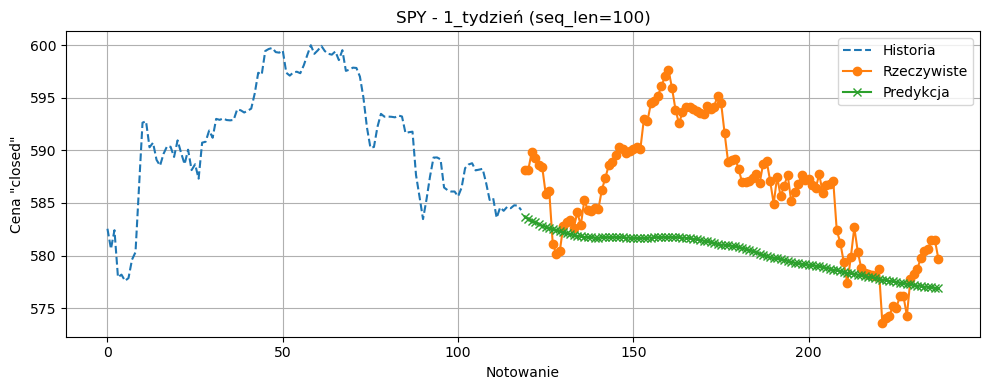

2_tygodnie | seq_len = 100 | MAPE = 2.18% | R2 = -2.5812


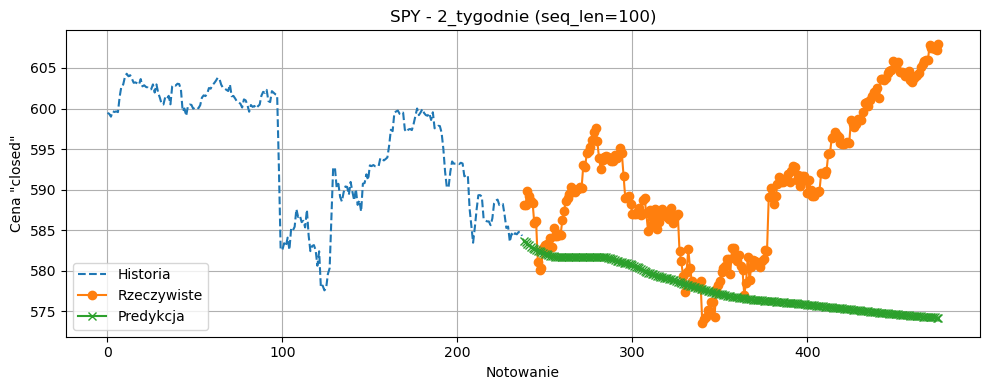

1_miesiąc | seq_len = 100 | MAPE = 2.92% | R2 = -4.1679


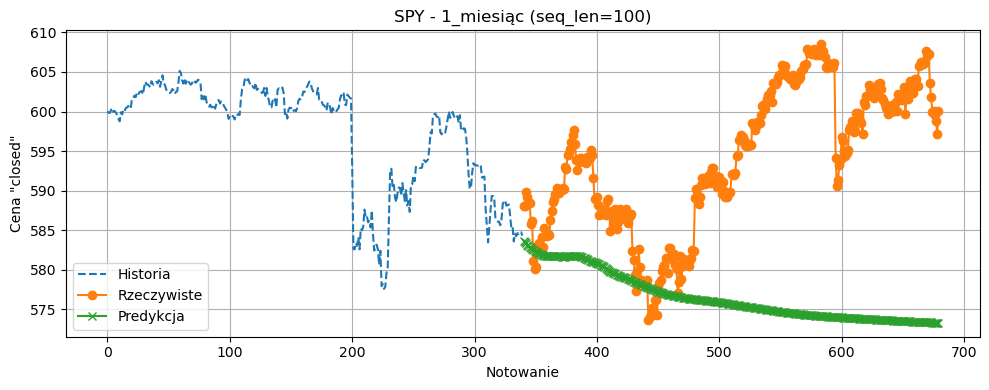

3_miesiące | seq_len = 100 | MAPE = 3.02% | R2 = -0.4885


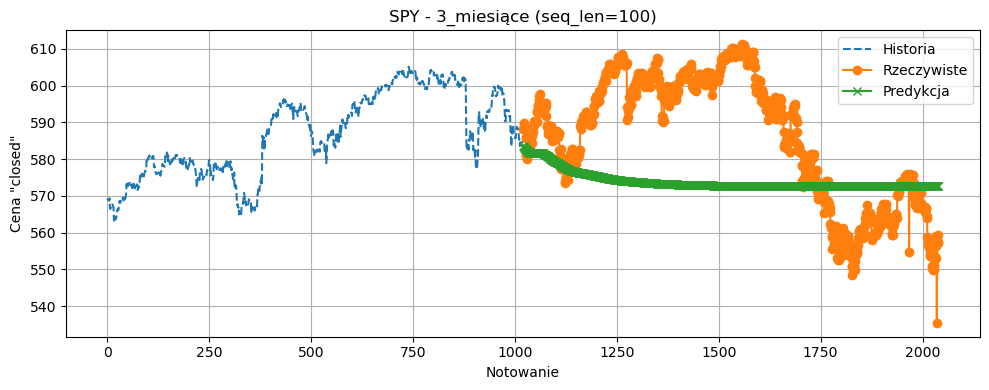

In [ ]:
all_results = []

for name, path in DATASETS.items():
    print(f"\n================= {name} =================\n")
    data, df_train, df_test = get_data(path)
    test_len = len(df_test)
    scaler_train = MinMaxScaler()
    train_scaled = scaler_train.fit_transform(df_train[['close']])
    test_values = df_test[['close']].values

    forecast_ranges = {}
    for label, source in FORECAST_INTERVALS.items():
        val = source[name]
        forecast_ranges[label] = test_len if val == "test_len" else val

    results_table = []
    best_results = {}

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    for seq_len in SEQ_LENGTHS:
        print(seq_len)
        X_train, y_train = create_mlp_sequences(train_scaled, seq_len)
        model = create_model_2(input_shape=(seq_len, 1))
        model.fit(X_train,
                y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1)

        # ZAPIS MODELU
        model_filename = f"wyniki_predykcji/{name.lower()}/model_seq{seq_len}.h5"
        os.makedirs(f"wyniki_predykcji/{name.lower()}", exist_ok=True)
        model.save(model_filename)

        initial_input = train_scaled[-seq_len:].flatten().tolist()
        pred_scaled = []
        input_seq = initial_input.copy()

        for _ in range(test_len):
            pred = model.predict(np.array(input_seq).reshape(1, seq_len), verbose=1)[0][0]
            pred_scaled.append(pred)
            input_seq = input_seq[1:] + [pred]

        pred_rescaled = scaler_train.inverse_transform(np.array(pred_scaled).reshape(-1, 1))

        for range_name, range_len in forecast_ranges.items():
            if range_len > len(pred_rescaled):
                continue
            pred_slice = pred_rescaled[:range_len].flatten()
            real_slice = test_values[:range_len].flatten()
            history_slice = df_train['close'].values[-range_len:]

            mape = np.mean(np.abs((real_slice - pred_slice) / real_slice)) * 100
            r2 = r2_score(real_slice, pred_slice)

            results_table.append({
                "Instrument": name,
                "Zakres": range_name,
                "Seq_len": seq_len,
                "MAPE": mape,
                "R2": r2
            })

            if (range_name not in best_results) or (mape < best_results[range_name]['mape']):
                best_results[range_name] = {
                    'seq_len': seq_len,
                    'mape': mape,
                    'r2': r2,
                    'real': real_slice,
                    'pred': pred_slice,
                    'history': history_slice,
                    'model_path': model_filename
                }

    df_results = pd.DataFrame(results_table)
    print(f"\nTabela wyników dla {name} (wszystkie zakresy i seq_len - MSE_%):\n")
    print(df_results.pivot_table(index='Seq_len', columns='Zakres', values='MAPE').round(2))

    print(f"\nNajlepsze modele dla {name} (najniższe MSE):\n")
    for range_name, res in best_results.items():
        print(f"{range_name} | seq_len = {res['seq_len']} | MAPE = {res['mape']:.2f}% | R2 = {res['r2']:.4f} | Model saved at: {res['model_path']}")

        plot_prediction(res['real'], res['pred'], res['history'], f"{name} - {range_name} (seq_len={res['seq_len']})")

    range_name_map = {
        "1_tydzień": "tyg",
        "2_tygodnie": "2tyg",
        "1_miesiąc": "msc",
        "3_miesiące": "3msc"
    }

    output_folder = f"wyniki_predykcji/{name.lower()}"
    os.makedirs(output_folder, exist_ok=True)

    for range_name, res in best_results.items():
        okres = range_name_map.get(range_name, range_name)
        podmiot = name.lower()

        # ZAPIS PREDYKCJI
        preds_filename = f"{podmiot}_{okres}_LSTM.txt"
        preds_filepath = os.path.join(output_folder, preds_filename)
        np.savetxt(preds_filepath, res["pred"], fmt="%.6f")

        # ZAPIS METRYK
        metrics_filename = f"{podmiot}_{okres}_LSTM_metrics.txt"
        metrics_filepath = os.path.join(output_folder, metrics_filename)
        with open(metrics_filepath, "w") as f:
            f.write(f"{res['mape']:.4f}\n")
            f.write(f"{res['r2']:.4f}\n")
            f.write(f"Model path: {res['model_path']}\n")

    all_results.append(df_results)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Możliwość fine-tuningu modelu

def fine_tune_model(dataset_name, model_path, seq_len, fine_tune_epochs=5, fine_tune_batch_size=32, learning_rate=0.0001):

    print(f"\n================= Fine-tuning model for {dataset_name} =================\n")
    
    # Załadowanie danych
    data, df_train, df_test = get_data(DATASETS[dataset_name])
    test_len = len(df_test)
    scaler_train = MinMaxScaler()
    train_scaled = scaler_train.fit_transform(df_train[['close']])
    test_values = df_test[['close']].values

    # Utworzenie sekwencji dla MLP
    X_train, y_train = create_mlp_sequences(train_scaled, seq_len)

    # Załadowanie modelu
    model = load_model(model_path)
    print(f"Loaded model from: {model_path}")

    # Dostosowanie architektury modelu
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mae'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Fine-tuning modelu
    model.fit(X_train,
              y_train,
              epochs=fine_tune_epochs,
              batch_size=fine_tune_batch_size,
              validation_split=0.2,
              callbacks=[early_stopping],
              verbose=1)

    # Zapisanie modelu
    fine_tuned_model_path = f"wyniki_predykcji/{dataset_name.lower()}/fine_tuned_model_seq{seq_len}.h5"
    os.makedirs(f"wyniki_predykcji/{dataset_name.lower()}", exist_ok=True)
    model.save(fine_tuned_model_path)
    print(f"Fine-tuned model saved to: {fine_tuned_model_path}")

    # Predykcja na danych testowych
    initial_input = train_scaled[-seq_len:].flatten().tolist()
    pred_scaled = []
    input_seq = initial_input.copy()

    for _ in range(test_len):
        pred = model.predict(np.array(input_seq).reshape(1, seq_len), verbose=0)[0][0]
        pred_scaled.append(pred)
        input_seq = input_seq[1:] + [pred]

    pred_rescaled = scaler_train.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
    real_slice = test_values[:test_len].flatten()
    history_slice = df_train['close'].values[-test_len:]

    # Obliczenie metryk
    mape = np.mean(np.abs((real_slice - pred_rescaled.flatten()) / real_slice)) * 100
    r2 = r2_score(real_slice, pred_rescaled.flatten())

    print(f"\nFine-tuned results for {dataset_name}:")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2: {r2:.4f}")

    # Wykres predykcji
    plot_prediction(real_slice, pred_rescaled.flatten(), history_slice, 
                    f"{dataset_name} - Fine-tuned (seq_len={seq_len})")

    # Zapis wyników do pliku
    metrics_filename = f"wyniki_predykcji/{dataset_name.lower()}/{dataset_name.lower()}_fine_tuned_metrics.txt"
    with open(metrics_filename, "w") as f:
        f.write(f"MAPE: {mape:.4f}\n")
        f.write(f"R2: {r2:.4f}\n")
        f.write(f"Fine-tuned model path: {fine_tuned_model_path}\n")

    return mape, r2, fine_tuned_model_path

# Użycie
for name in DATASETS.keys():
    for seq_len in SEQ_LENGTHS:
        model_path = f"wyniki_predykcji/{name.lower()}/model_seq{seq_len}.h5"
        if os.path.exists(model_path):
            fine_tune_model(name, model_path, seq_len)